## Basic setup

In [1]:
## Import packages
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
# Load wine dataset 
df = pd.read_csv('winemag-data_first150k.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [3]:
df[df['variety']=='Rh\xc3\xb4ne-style Red Blend']['variety'] = 'Rhone-style Red Blend'

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:
def remove_weird_char(string):
    words = string.lower().split()
    refined = []
    for i in words:
        refined.append(re.sub("[^\w-]+", "", i))
        sentence = ' '.join([word for word in refined])
    return(sentence)

In [5]:
#Clean up that description column
df['description'] = df['description'].str.lower()
df['description'] = df['description'].apply(remove_weird_char)

df['description'].head()

0    this tremendous 100 varietal wine hails from o...
1    ripe aromas of fig blackberry and cassis are s...
2    mac watson honors the memory of a wine once ma...
3    this spent 20 months in 30 new french oak and ...
4    this is the top wine from la bgude named after...
Name: description, dtype: object

In [6]:
## Remove stopwords
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
cachedStopWords.append('wine')
def rmStopWords(text):
        text = ' '.join([word for word in text.split() if word not in cachedStopWords])
        return(text)

In [7]:
df['description']=df['description'].apply(rmStopWords)

In [8]:
df = df[['variety', 'description']]
df.head()

,variety,description
0,Cabernet Sauvignon,tremendous 100 varietal hails oakville aged th...
1,Tinta de Toro,ripe aromas fig blackberry cassis softened swe...
2,Sauvignon Blanc,mac watson honors memory made mother tremendou...
3,Pinot Noir,spent 20 months 30 new french oak incorporates...
4,Provence red blend,top la bgude named highest point vineyard 1200...


## Calculate lift values

In [9]:
df['variety'].value_counts()[:25]

Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Red Blend                        10062
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
White Blend                       2824
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Sparkling Blend                   2004
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Rhône-style Red Blend             1505
Barbera                           1365
Pinot Gris                        1365
Cabernet Franc                    1363
Sangiovese Grosso                 1346
Name: variety, dtype: int

In [10]:
top_varieties = list(df['variety'].value_counts()[:25].index)

mask = df['variety'].isin(top_varieties)
new_df = df[mask]
new_df.head()

,variety,description
0,Cabernet Sauvignon,tremendous 100 varietal hails oakville aged th...
2,Sauvignon Blanc,mac watson honors memory made mother tremendou...
3,Pinot Noir,spent 20 months 30 new french oak incorporates...
8,Pinot Noir,re-named vineyard formerly bottled delancellot...
9,Pinot Noir,producer sources two blocks vineyard wineone h...


In [11]:
#dealing with top 25 vatieties
len(top_varieties)

25

In [12]:
all_desc = new_df['description'].str.cat(sep=' ')

pos_df = pd.DataFrame(all_desc.split(), columns=['word'])
pos_df['word'].value_counts()[:20]

flavors    61718
fruit      44565
finish     29191
tannins    27792
cherry     26710
aromas     25914
acidity    24047
palate     21410
ripe       21177
black      20950
drink      18948
dry        18683
spice      17896
oak        17412
rich       16876
sweet      16222
red        15624
notes      15345
soft       13963
good       13865
Name: word, dtype: int64

In [13]:
attribute_list = pos_df['word'].value_counts()[:20].index

In [14]:
#calculate lift values

def calc_lift(a, b):
    total_size = len(df)
    filter_a = df[df['variety']==a]
    num_a = len(filter_a)
    num_b = len(df[df['description'].str.contains(b)])
    num_a_b = len(filter_a['description'][filter_a['description'].str.contains(b)])
    if num_a_b==0:
        return .2
    return total_size*float(num_a_b)/float(num_a*num_b)

In [15]:
lift_df = pd.DataFrame(columns=top_varieties, index=attribute_list)

for attribute, series in list(lift_df.iterrows()):
    for variety in series.index:
        lift_df[variety].loc[attribute] = calc_lift(variety, attribute)

lift_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
flavors,1.18142,1.11135,1.19422,0.87089,0.708477,1.26915,1.12957,1.01437,1.1682,1.30949,...,0.203857,0.632153,1.13277,0.905026,0.367751,0.942886,0.419095,1.09439,1.02332,0.2493
fruit,1.05548,0.918733,0.823677,0.958115,1.3923,1.16807,1.00323,0.914565,0.902196,0.646832,...,0.778918,1.70963,0.708292,1.10576,0.998762,0.928142,1.10749,1.13303,0.987216,0.984445
finish,0.992232,0.79859,0.987778,0.960375,0.521282,1.26491,0.974459,1.63065,1.08394,0.835554,...,0.786586,0.261128,1.1016,1.79468,0.538916,1.43573,0.686125,1.22522,1.05278,0.397606
tannins,0.0344001,1.18253,1.88859,1.37286,2.61356,0.0137755,1.41324,0.00875584,1.59412,1.2617,...,2.45182,3.03823,0.0120677,1.36263,0.600996,1.59403,0.687417,0.0106302,1.97301,1.04568
cherry,0.00366616,2.14804,1.36165,1.72354,0.502573,0.00305486,1.22966,0.0463095,2.14677,1.27178,...,2.04611,0.148111,0.284205,0.83303,2.25264,1.75107,1.80337,0.0106081,1.92288,2.41692
aromas,0.694951,0.391973,0.783938,1.45942,0.375707,0.959249,0.705318,0.839519,0.859157,0.23471,...,2.6329,0.177122,1.37953,1.26907,1.97337,0.722867,1.70966,0.456326,0.766875,1.93665
acidity,1.51651,1.21039,0.409767,0.454176,1.23246,1.38418,0.496008,1.46997,0.496309,0.43867,...,0.617247,2.05372,0.968227,0.277987,0.241382,0.555226,1.46645,1.18284,0.8486,0.624321
palate,0.857628,0.611921,0.907788,1.32543,0.400185,0.963888,0.765766,1.62228,0.936402,0.291549,...,1.53664,0.124954,1.3139,1.29824,0.404079,1.03032,0.925762,1.06223,1.00838,0.370296
ripe,1.1629,1.00893,1.15446,0.93124,1.5286,0.981256,1.01474,0.966535,1.01008,1.32506,...,0.836679,1.75564,0.355393,0.58287,0.901588,0.80481,0.72763,0.97254,1.03795,0.795494
black,0.0040928,0.676042,2.32272,1.60697,1.93297,0.00687754,2.04865,0.0150218,1.57435,1.6975,...,1.24839,1.73679,0.00394357,1.5846,1.25921,1.49657,1.73112,0.0231587,1.20022,1.40033


In [16]:
s = pos_df['word'].value_counts()
len(s[s>100])

2665

## Aishwarya Stuff

In [282]:
import networkx as nx
from networkx.algorithms import bipartite

### Get variety-attribute combinations with lift values>2

In [283]:
df = lift_df[:10].stack().reset_index()
df.columns = [['attribute','variety','lift']]
df.sort_values(by='lift',ascending=False,inplace=True)
df2 = df[df['lift']>2]
df2

,attribute,variety,lift
91,tannins,Portuguese Red,3.03823
110,cherry,Sangiovese,2.67956
140,aromas,Nebbiolo,2.6329
79,tannins,Bordeaux-style Red Blend,2.61356
90,tannins,Nebbiolo,2.45182
124,cherry,Sangiovese Grosso,2.41692
227,black,Cabernet Sauvignon,2.32272
189,palate,Tempranillo,2.31044
119,cherry,"Corvina, Rondinella, Molinara",2.25264
139,aromas,Tempranillo,2.22998


### Bi-partite graph for variety-attribute associations

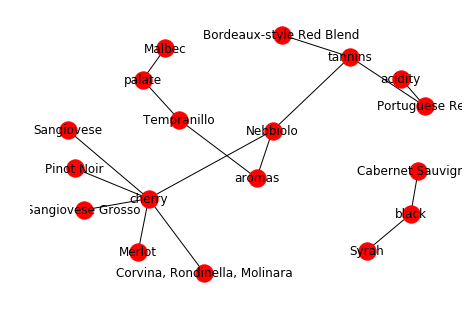

In [284]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
G = nx.Graph()
G.add_nodes_from(df2['attribute'], bipartite=0) # Add the node attribute "bipartite"
G.add_nodes_from(df2['variety'], bipartite=1)
edges = [tuple(x) for x in df2[['attribute','variety']].to_records(index=False)]
G.add_edges_from(edges)
c = bipartite.color(G)
nx.set_node_attributes(G, 'bipartite',c)
# num_edges = G.number_of_edges()
# num_nodes = G.number_of_nodes()
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True,
#         edge_color=np.random.random(num_edges), 
#         edge_cmap=plt.get_cmap('Blues'),
#         node_color=np.random.random(num_nodes),
#         cmap=plt.get_cmap('Reds')
       )
plt.figure(figsize=(100,100))
plt.show()

## Bryan's stuff

In [17]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    final = set()
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        final = final.union(set(feature_names[j] for j in top10))
    return final

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from operator import itemgetter
from sklearn.metrics import classification_report

vectorizer = CountVectorizer()


trainset_size = int(round(len(new_df)*0.80))
X_train = new_df["description"].iloc[1:trainset_size,]
y_train = new_df["variety"].iloc[1:trainset_size,]

X_test = new_df["description"].iloc[trainset_size:,]
y_test = new_df["variety"].iloc[trainset_size:,]

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [20]:
predictive_attributes = list(print_top10(vectorizer, nb_classifier, top_varieties))
len(predictive_attributes)

67

## Vectorize each variety

In [21]:
#calculate vectors

def calc_vect(a, b):
    temp_string = df[df['variety']==a]['description'].str.cat(sep=' ')
    return temp_string.count(b)

# note the attribute features chosen as the words most predictive in Naive Bayes model

In [22]:
vector_df = pd.DataFrame(columns=top_varieties, index=predictive_attributes)

for attribute, series in list(vector_df.iterrows()):
    for variety in series.index:
        vector_df[variety].loc[attribute] = calc_vect(variety, attribute)

vector_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
malbec,0,4,149,494,278,2,9,0,45,0,...,0,3,3,0,0,1,0,0,8,0
apple,8200,97,33,51,2,1712,39,2475,17,3,...,37,2,797,4,131,11,23,541,21,16
sweet,2423,2053,2600,1611,1237,1065,957,1839,879,1234,...,156,280,591,206,405,184,225,287,248,210
bright,1165,789,307,876,320,481,305,438,197,92,...,406,127,155,95,289,115,382,85,95,384
brunello,0,0,0,5,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,773
ros,391,1014,320,475,121,99,245,213,135,63,...,331,35,308,152,66,91,27,51,72,345
cola,20,4115,2728,2200,830,5,1290,4,1045,1062,...,502,147,27,456,623,286,229,5,196,387
flavors,8867,8132,7886,4556,2698,4113,3453,2860,3083,2539,...,234,741,1161,912,315,721,296,764,736,170
shiraz,3,7,4,153,1,3,23,3,1,0,...,0,2,4,966,0,38,0,0,0,0
noir,29,3638,20,109,13,19,24,0,10,24,...,3,5,309,0,0,9,0,5,4,0


In [23]:
#calculate cosine similarities 

from scipy import spatial
def calc_cos(series_A, series_B):
    sim = round(1 - spatial.distance.cosine(series_A, series_B),3)
    if sim==1:
        return np.nan
    return sim

In [24]:
cos_df = pd.DataFrame(columns=top_varieties, index=top_varieties)

for variety_A, series in list(cos_df.iterrows()):
    for variety_B in series.index:
        cos_df[variety_B].loc[variety_A] = calc_cos(vector_df[variety_B], vector_df[variety_A])

cos_df

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
Chardonnay,NaN,0.633,0.523,0.511,0.59,0.831,0.552,0.814,0.588,0.475,...,0.462,0.598,0.827,0.581,0.511,0.545,0.517,0.829,0.579,0.442
Pinot Noir,0.633,NaN,0.747,0.747,0.749,0.638,0.789,0.601,0.834,0.727,...,0.722,0.737,0.727,0.776,0.734,0.795,0.709,0.682,0.793,0.695
Cabernet Sauvignon,0.523,0.747,NaN,0.881,0.843,0.534,0.846,0.494,0.86,0.753,...,0.704,0.693,0.553,0.791,0.689,0.779,0.709,0.482,0.904,0.655
Red Blend,0.511,0.747,0.881,NaN,0.835,0.562,0.832,0.502,0.865,0.708,...,0.772,0.693,0.603,0.798,0.77,0.877,0.744,0.492,0.883,0.727
Bordeaux-style Red Blend,0.59,0.749,0.843,0.835,NaN,0.621,0.789,0.549,0.818,0.67,...,0.686,0.935,0.548,0.743,0.668,0.768,0.692,0.572,0.859,0.638
Sauvignon Blanc,0.831,0.638,0.534,0.562,0.621,NaN,0.585,0.84,0.606,0.509,...,0.475,0.614,0.819,0.613,0.51,0.568,0.545,0.823,0.605,0.452
Syrah,0.552,0.789,0.846,0.832,0.789,0.585,NaN,0.536,0.86,0.801,...,0.738,0.743,0.597,0.85,0.741,0.898,0.762,0.538,0.789,0.702
Riesling,0.814,0.601,0.494,0.502,0.549,0.84,0.536,NaN,0.568,0.498,...,0.48,0.549,0.835,0.579,0.494,0.557,0.518,0.84,0.564,0.435
Merlot,0.588,0.834,0.86,0.865,0.818,0.606,0.86,0.568,NaN,0.771,...,0.769,0.722,0.628,0.833,0.767,0.837,0.754,0.552,0.85,0.722
Zinfandel,0.475,0.727,0.753,0.708,0.67,0.509,0.801,0.498,0.771,NaN,...,0.625,0.617,0.552,0.719,0.656,0.73,0.646,0.487,0.702,0.606


In [25]:
#most similar varieties using cosine similarity
cos_df.idxmax(axis=0)

Chardonnay                                     Sauvignon Blanc
Pinot Noir                                              Merlot
Cabernet Sauvignon                              Cabernet Franc
Red Blend                                       Cabernet Franc
Bordeaux-style Red Blend                        Portuguese Red
Sauvignon Blanc                                       Riesling
Syrah                                    Rhône-style Red Blend
Riesling                                       Sauvignon Blanc
Merlot                                              Sangiovese
Zinfandel                                                Syrah
Sangiovese                                            Nebbiolo
Malbec                                             Tempranillo
White Blend                                    Sauvignon Blanc
Rosé                                                Pinot Noir
Tempranillo                                             Malbec
Nebbiolo                                            San

### MDS Map (using Cossine similarity)
Calculated Dissimilarity

Note: Output data to csv and plot in R

In [115]:
#make dissimilarity matrix and plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

dissimilarity = 1-cos_df
adist = np.array(dissimilarity,dtype='float64')
amax = dissimilarity.max().max()
adist /= amax
adist = np.nan_to_num(adist)

In [116]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)

In [117]:
coords = results.embedding_

In [118]:
col_names = dissimilarity.columns.values
col_names[13] = 'Rose'
col_names[20] = 'Rhone-style Red Blend'
col_names

array(['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend',
       'Bordeaux-style Red Blend', 'Sauvignon Blanc', 'Syrah', 'Riesling',
       'Merlot', 'Zinfandel', 'Sangiovese', 'Malbec', 'White Blend',
       'Rose', 'Tempranillo', 'Nebbiolo', 'Portuguese Red',
       'Sparkling Blend', 'Shiraz', 'Corvina, Rondinella, Molinara',
       'Rhone-style Red Blend', 'Barbera', 'Pinot Gris', 'Cabernet Franc',
       'Sangiovese Grosso'], dtype=object)

In [126]:
MDS_df = pd.DataFrame({'names':col_names, 'x_vals':coords[:, 0],
             'y_vales':coords[:, 1]})
MDS_df.to_csv('MDS_cluster.csv')

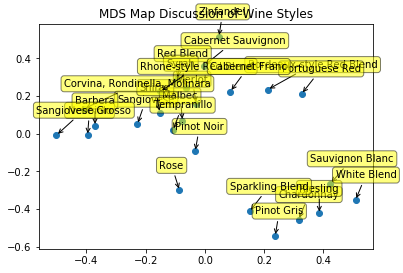

In [119]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
plt.title('MDS Map Discussion of Wine Styles')
for label, x, y in zip(col_names, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=.3', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

## Most prevalent words for Chardonnay and Sauvignon Blanc

In [26]:
list_a = []
list_b = []
for attribute in predictive_attributes:
    list_a.append(float(sum(df[df['variety']=='Chardonnay']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Chardonnay'])))
    list_b.append(float(sum(df[df['variety']=='Sauvignon Blanc']['description'].str.contains(str(attribute))))/float(len(df[df['variety']=='Sauvignon Blanc'])))

In [27]:
new = pd.DataFrame([predictive_attributes, list_a, list_b]).T
new.columns = ['attribute', 'count_a', 'count_b']
new['avg'] = (new['count_a']+new['count_b'])/2.0
new.sort_values('avg', ascending=False, inplace=True)

In [28]:
print new['attribute'][:5].values

[u'flavors' u'fruit' u'apple' u'finish' u'acidity']


### K-means Clustering

In [48]:
def sorted(s, num):
    tmp = s.sort_values(ascending=False)[:num]  # earlier s.order(..)
    return tmp
kmdf = vector_df.apply(lambda x: sorted(x, 25))
kmdf

,Chardonnay,Pinot Noir,Cabernet Sauvignon,Red Blend,Bordeaux-style Red Blend,Sauvignon Blanc,Syrah,Riesling,Merlot,Zinfandel,...,Nebbiolo,Portuguese Red,Sparkling Blend,Shiraz,"Corvina, Rondinella, Molinara",Rhône-style Red Blend,Barbera,Pinot Gris,Cabernet Franc,Sangiovese Grosso
acidity,4750.0,3726.0,NaN,NaN,1967.0,1877.0,625.0,1751.0,536.0,353.0,...,293.0,984.0,422.0,NaN,NaN,180.0,424.0,347.0,246.0,178.0
alcohol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,984.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amarone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,461.0,NaN,NaN,NaN,NaN,NaN
apple,8200.0,NaN,NaN,NaN,NaN,1712.0,NaN,2475.0,NaN,NaN,...,NaN,NaN,797.0,NaN,NaN,NaN,NaN,541.0,NaN,NaN
aromas,2384.0,NaN,2376.0,3487.0,NaN,1438.0,978.0,1104.0,1037.0,NaN,...,1436.0,92.0,657.0,591.0,793.0,256.0,561.0,147.0,245.0,653.0
barbera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,905.0,NaN,NaN,NaN
barolo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,764.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
barrel,NaN,NaN,NaN,NaN,1709.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
berry,NaN,6035.0,6861.0,5887.0,2253.0,621.0,3537.0,NaN,2417.0,2296.0,...,1208.0,742.0,531.0,1163.0,728.0,750.0,848.0,NaN,600.0,698.0
black,NaN,2752.0,9303.0,5286.0,4043.0,NaN,3948.0,NaN,2390.0,1946.0,...,818.0,1047.0,NaN,941.0,595.0,713.0,742.0,NaN,508.0,537.0


In [49]:
kmdict = kmdf.to_dict(orient='dict')
for listing, rate in kmdict.items():
    kmdict[listing] = {k: v for k, v in rate.items() if pd.notnull(v)}

In [50]:
kmdict

{'Barbera': {u'acidity': 424.0,
  u'aromas': 561.0,
  u'barbera': 905.0,
  u'berry': 848.0,
  u'black': 742.0,
  u'blackberry': 310.0,
  u'bright': 382.0,
  u'cherry': 529.0,
  u'chocolate': 175.0,
  u'cola': 229.0,
  u'finish': 281.0,
  u'flavors': 296.0,
  u'fresh': 373.0,
  u'fruit': 859.0,
  u'notes': 342.0,
  u'oak': 275.0,
  u'offers': 233.0,
  u'palate': 259.0,
  u'plum': 203.0,
  u'red': 280.0,
  u'rich': 193.0,
  u'ripe': 219.0,
  u'spice': 506.0,
  u'sweet': 225.0,
  u'tannins': 196.0},
 'Bordeaux-style Red Blend': {u'acidity': 1967.0,
  u'barrel': 1709.0,
  u'berry': 2253.0,
  u'black': 4043.0,
  u'blackberry': 957.0,
  u'blend': 1614.0,
  u'cab': 2073.0,
  u'cabernet': 1706.0,
  u'drink': 1508.0,
  u'dry': 1473.0,
  u'finish': 1156.0,
  u'flavors': 2698.0,
  u'fresh': 1269.0,
  u'fruit': 6358.0,
  u'fruits': 1824.0,
  u'merlot': 1175.0,
  u'plum': 1002.0,
  u'red': 2462.0,
  u'rich': 2035.0,
  u'ripe': 2519.0,
  u'sauvignon': 941.0,
  u'spice': 1082.0,
  u'sweet': 1237.0,
 

In [51]:
kmdictnew = {} 
for k, v in kmdict.iteritems():
    innervals = []
    for innerk, innerv in v.iteritems():
        innervals.append(innerk)
    kmdictnew[k] = innervals
kmdictnew

{'Barbera': [u'tannins',
  u'palate',
  u'ripe',
  u'sweet',
  u'barbera',
  u'bright',
  u'cola',
  u'flavors',
  u'acidity',
  u'cherry',
  u'oak',
  u'offers',
  u'black',
  u'rich',
  u'red',
  u'berry',
  u'finish',
  u'chocolate',
  u'fruit',
  u'spice',
  u'notes',
  u'aromas',
  u'blackberry',
  u'fresh',
  u'plum'],
 'Bordeaux-style Red Blend': [u'tannins',
  u'ripe',
  u'sweet',
  u'flavors',
  u'acidity',
  u'merlot',
  u'wood',
  u'black',
  u'rich',
  u'red',
  u'blackberry',
  u'finish',
  u'sauvignon',
  u'drink',
  u'fruit',
  u'cab',
  u'cabernet',
  u'spice',
  u'dry',
  u'plum',
  u'berry',
  u'fruits',
  u'fresh',
  u'barrel',
  u'blend'],
 'Cabernet Franc': [u'tannins',
  u'palate',
  u'ripe',
  u'sweet',
  u'cola',
  u'flavors',
  u'acidity',
  u'cherry',
  u'oak',
  u'black',
  u'rich',
  u'red',
  u'franc',
  u'finish',
  u'drink',
  u'fruit',
  u'cab',
  u'cabernet',
  u'spice',
  u'dry',
  u'notes',
  u'aromas',
  u'berry',
  u'fresh',
  u'plum'],
 'Cabernet S

In [52]:
kmdict_phrases = pd.DataFrame.from_dict(kmdictnew)

In [53]:
kmdict_phrases

,Barbera,Bordeaux-style Red Blend,Cabernet Franc,Cabernet Sauvignon,Chardonnay,"Corvina, Rondinella, Molinara",Malbec,Merlot,Nebbiolo,Pinot Gris,...,Rosé,Sangiovese,Sangiovese Grosso,Sauvignon Blanc,Shiraz,Sparkling Blend,Syrah,Tempranillo,White Blend,Zinfandel
0,tannins,tannins,tannins,tannins,palate,tannins,tannins,tannins,tannins,palate,...,palate,tannins,tannins,palate,tannins,palate,tannins,tannins,palate,tannins
1,palate,ripe,palate,palate,apple,ripe,malbec,palate,palate,apple,...,ripe,palate,acidity,apple,palate,apple,palate,palate,apple,palate
2,ripe,sweet,ripe,ripe,acidity,sweet,palate,ripe,ripe,acidity,...,sweet,ripe,sweet,acidity,ripe,acidity,ripe,ripe,acidity,acidity
3,sweet,flavors,sweet,cassis,sweet,bright,ripe,sweet,barolo,sweet,...,bright,sweet,bright,sweet,sweet,sweet,sweet,sweet,sweet,sweet
4,barbera,acidity,cola,sweet,flavors,cola,sweet,cola,bright,pinot,...,ros,bright,brunello,blanc,cola,pinot,cola,cola,blanc,cola
5,bright,merlot,flavors,cola,ripe,flavors,cola,flavors,ros,finish,...,flavors,cola,ros,flavors,flavors,ros,flavors,flavors,flavors,flavors
6,cola,wood,acidity,flavors,oak,amarone,flavors,acidity,cola,flavors,...,acidity,flavors,cola,ripe,shiraz,flavors,acidity,acidity,offers,alcohol
7,flavors,black,cherry,cherry,rich,plum,acidity,cherry,acidity,ripe,...,cherry,acidity,flavors,rich,plum,noir,cherry,plum,rich,ripe
8,acidity,rich,oak,oak,white,cherry,cherry,oak,cherry,rich,...,rich,cherry,ripe,white,cherry,sparkling,oak,cherry,white,cherry
9,cherry,red,black,black,red,oak,oak,merlot,oak,white,...,red,oak,plum,red,oak,rich,black,oak,red,oak


In [54]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(kmdict_phrases)

true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

#Note:: Something didn't work here, because the clusters are just a mix
# of reds and whites, with some of the same words.

# This is likely because the actual dictionary "kmdict_phrases" consists
# of mostly the same attributes for many wines... eg/ "tannin"

#Note2:: I tried 5, 10, and 25 attributes for each wine type... none work
# particularly well.

#Code adopted from here: https://pythonprogramminglanguage.com/kmeans-text-clustering/

Top terms per cluster:
Cluster 0:  pinot  blend  sparkling  white  gris  noir  cabernet  chardonnay  nebbiolo  franc
Cluster 1:  red  blend  style  portuguese  bordeaux  rhône  zinfandel  gris  malbec  grosso
Cluster 2:  sangiovese  cabernet  sauvignon  zinfandel  riesling  chardonnay  malbec  merlot  nebbiolo  barbera
